# 03 - Agent Training (Interactive)

**Goal:** Train our DQN agent and watch it learn in real-time!

---

## What Happens During Training

1. **Agent observes** market state (21 technical indicators)
2. **Agent chooses action** (Long, Short, or Hold)
3. **Environment responds** with new state and reward
4. **Agent learns** by updating Q-values
5. **Repeat** for thousands of timesteps

## What We'll Visualize

- Episode rewards over time (is it learning?)
- Exploration vs exploitation (epsilon decay)
- Episode lengths
- Training statistics

## TensorBoard

All metrics are also logged to TensorBoard for detailed analysis!

**To view in TensorBoard:**
```bash
tensorboard --logdir=demo_logs
```
Then open: http://localhost:6006

---

In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import the training function
from train_agent import train_dqn_agent

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

# Check device
if torch.xpu.is_available():
    device = 'xpu'
    print(f"✓ Using Intel XPU: {torch.xpu.get_device_name(0)}")
elif torch.cuda.is_available():
    device = 'cuda'
    print(f"✓ Using CUDA GPU")
else:
    device = 'cpu'
    print("Using CPU (training will be slower)")

✓ Imports successful
✓ Using Intel XPU: Intel(R) Arc(TM) Graphics


## Load Data

Load the processed data from notebooks 01 and 02.

In [2]:
# Load data
print("Loading data...")
data = pd.read_parquet('demo_data/featured_data.parquet')

print(f"✓ Loaded {len(data)} rows")
print(f"  Date range: {data.index[0]} to {data.index[-1]}")
print(f"  Features: {len(data.columns)} columns")

Loading data...
✓ Loaded 6089 rows
  Date range: 2000-10-16 00:00:00 to 2024-12-30 00:00:00
  Features: 41 columns


## Split Data

Split into train/validation/test sets (time-series aware).

- **Train**: Early data for learning
- **Validation**: Middle data for model selection
- **Test**: Recent data (2021+) held out for final evaluation

In [3]:
# Define test period
test_start = pd.Timestamp('2021-01-01')

# Split train+val from test
train_val_data = data[data.index < test_start].copy()
test_data = data[data.index >= test_start].copy()

# Split train from validation (85/15 split)
train_size = int(len(train_val_data) * 0.85)
train_data = train_val_data.iloc[:train_size]
val_data = train_val_data.iloc[train_size:]

print("Data splits:")
print(f"  Train:      {len(train_data):5d} rows | {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"  Validation: {len(val_data):5d} rows | {val_data.index[0].date()} to {val_data.index[-1].date()}")
print(f"  Test:       {len(test_data):5d} rows | {test_data.index[0].date()} to {test_data.index[-1].date()}")

Data splits:
  Train:       4322 rows | 2000-10-16 to 2017-12-19
  Validation:   763 rows | 2017-12-20 to 2020-12-31
  Test:        1004 rows | 2021-01-04 to 2024-12-30


## Define Features

These 21 features will be the agent's observation space (what it "sees" about the market).

In [4]:
features = [
    # Returns (momentum)
    'return_1d', 'return_5d', 'return_10d',
    
    # Momentum indicators
    'rsi', 'rsi_norm', 'macd', 'macd_signal', 'macd_diff',
    
    # Trend indicators
    'sma_50', 'sma_200', 'sma_crossover', 'ema_12', 'ema_26',
    
    # Volatility indicators
    'bb_high', 'bb_low', 'bb_width', 'bb_percent', 'atr', 'atr_pct',
    
    # Volume indicators
    'volume_ratio', 'obv'
]

print(f"Using {len(features)} features for agent state space:")
for i, f in enumerate(features, 1):
    print(f"  {i:2d}. {f}")

Using 21 features for agent state space:
   1. return_1d
   2. return_5d
   3. return_10d
   4. rsi
   5. rsi_norm
   6. macd
   7. macd_signal
   8. macd_diff
   9. sma_50
  10. sma_200
  11. sma_crossover
  12. ema_12
  13. ema_26
  14. bb_high
  15. bb_low
  16. bb_width
  17. bb_percent
  18. atr
  19. atr_pct
  20. volume_ratio
  21. obv


## Train the Agent! 🚀

This cell will:
1. Create train and validation environments
2. Initialize DQN agent
3. Train for 30,000 timesteps (~10-30 minutes)
4. Show **live plots** updating every 1,500 steps
5. Log everything to TensorBoard
6. Save best model to `demo_models/dqn_agent/best_model.zip`

**Watch the plots below update in real-time!**

You'll see:
- Episode rewards increasing (hopefully!)
- Exploration rate decreasing (agent becoming more confident)
- Episode lengths
- Training statistics

**Note**: This will take 10-30 minutes depending on your hardware. Be patient!

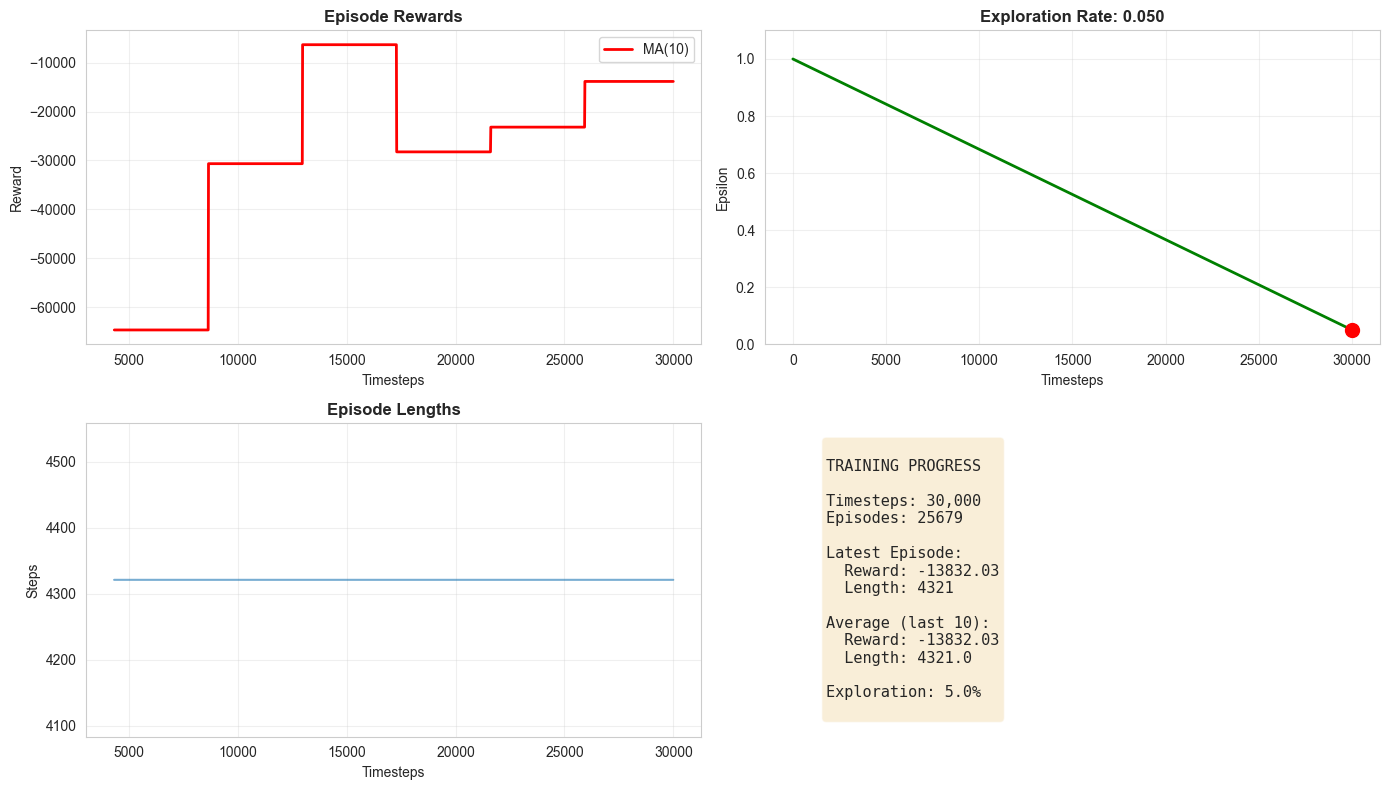

Eval num_timesteps=30000, episode_reward=13758.08 +/- 0.00

Episode length: 762.00 +/- 0.00

\n======================================================================
TRAINING COMPLETE!
  Total episodes: 25679
  Best model saved to: demo_models/dqn_agent/best_model.zip
  Final model saved to: demo_models/dqn_agent/final_model.zip

🎉 TRAINING COMPLETE! 🎉


In [5]:
# Train the agent with live visualization
model, callback = train_dqn_agent(
    train_data=train_data,
    val_data=val_data,
    features=features,
    device=device,
    total_timesteps=30000,  # Adjust this: 20000 for quick test, 50000+ for better results
    plot_freq=1500          # Update plots every 1500 steps
)

print("\n" + "="*70)
print("🎉 TRAINING COMPLETE! 🎉")
print("="*70)

## Training Summary

Let's look at the final training statistics.

In [6]:
# Training summary
print("TRAINING SUMMARY")
print("="*70)
print(f"Total episodes completed: {len(callback.episode_rewards)}")
print(f"Total timesteps: {callback.timesteps[-1] if callback.timesteps else 0:,}")
print()
print("Episode Rewards:")
print(f"  First 10 episodes avg: {np.mean(callback.episode_rewards[:10]):.2f}")
print(f"  Last 10 episodes avg:  {np.mean(callback.episode_rewards[-10:]):.2f}")
print(f"  Best episode reward:   {max(callback.episode_rewards):.2f}")
print(f"  Worst episode reward:  {min(callback.episode_rewards):.2f}")
print()
print("Episode Lengths:")
print(f"  Average length: {np.mean(callback.episode_lengths):.1f} steps")
print(f"  Min length: {min(callback.episode_lengths)}")
print(f"  Max length: {max(callback.episode_lengths)}")
print()
print("Model saved to:")
print(f"  Best model:  demo_models/dqn_agent/best_model.zip")
print(f"  Final model: demo_models/dqn_agent/final_model.zip")
print()
print("TensorBoard logs: demo_logs/")
print("  View with: tensorboard --logdir=demo_logs")

TRAINING SUMMARY
Total episodes completed: 25679
Total timesteps: 30,000

Episode Rewards:
  First 10 episodes avg: -64682.04
  Last 10 episodes avg:  -13832.03
  Best episode reward:   -6315.50
  Worst episode reward:  -64682.04

Episode Lengths:
  Average length: 4321.0 steps
  Min length: 4321
  Max length: 4321

Model saved to:
  Best model:  demo_models/dqn_agent/best_model.zip
  Final model: demo_models/dqn_agent/final_model.zip

TensorBoard logs: demo_logs/
  View with: tensorboard --logdir=demo_logs


## Plot Final Training Curves

Let's create a comprehensive view of the training process.


✓ Saved training results to: demo_outputs/training_results.png


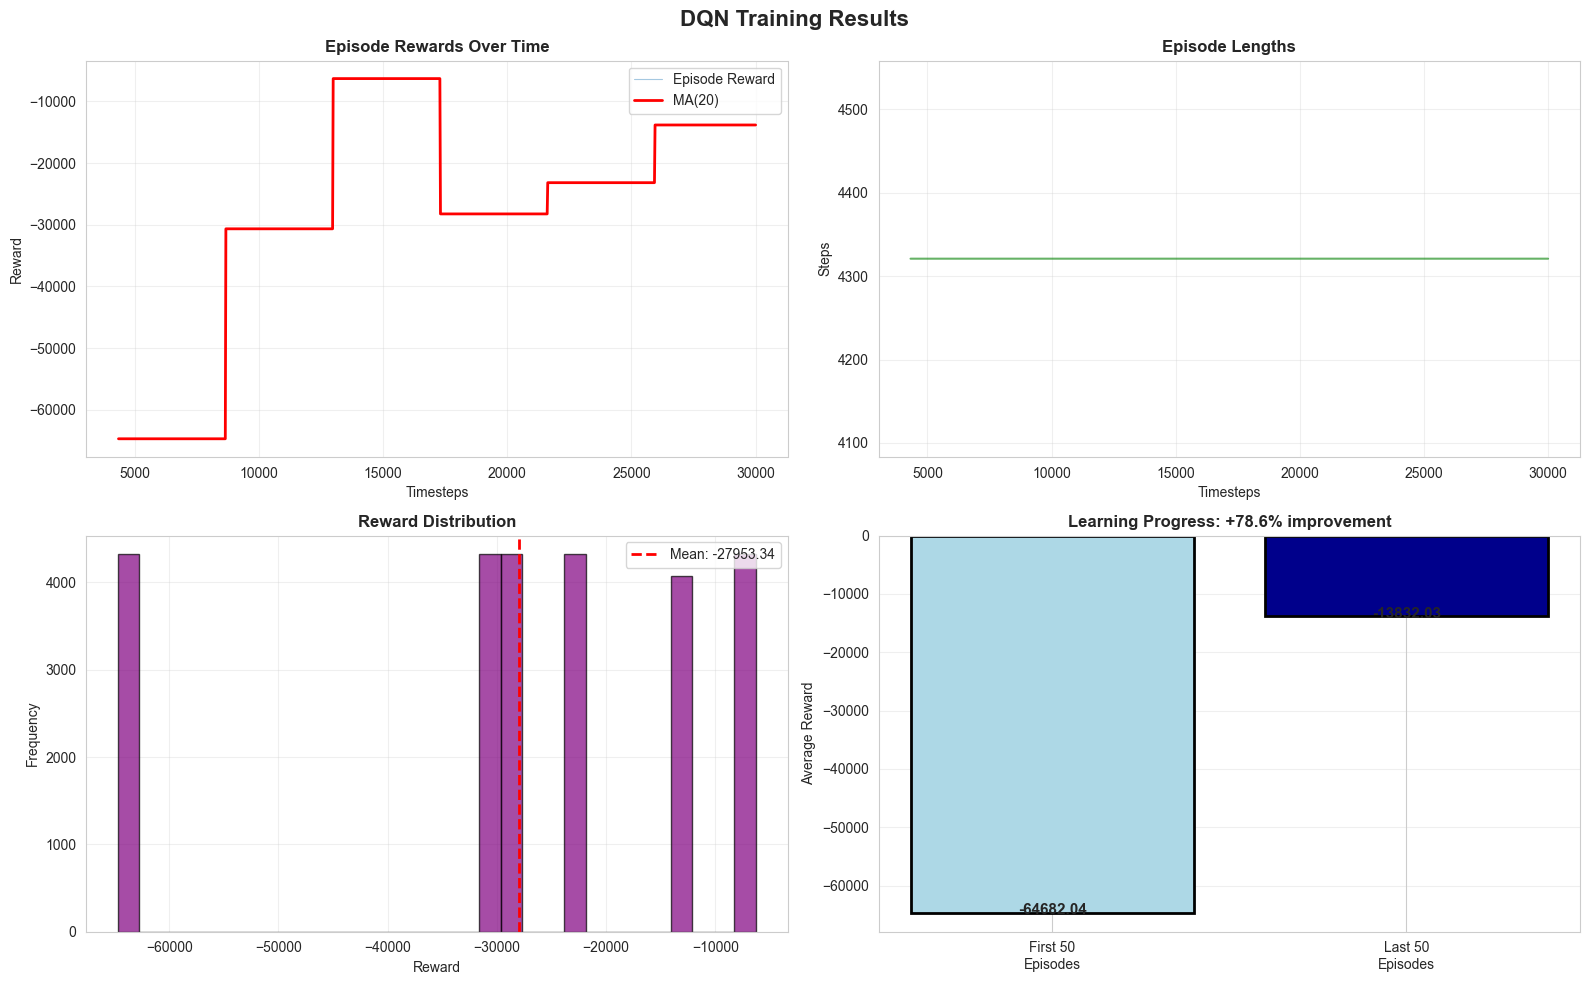

In [7]:
# Create final training visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('DQN Training Results', fontsize=16, fontweight='bold')

# 1. Episode rewards
ax1 = axes[0, 0]
ax1.plot(callback.timesteps, callback.episode_rewards, alpha=0.4, linewidth=0.8, label='Episode Reward')
if len(callback.episode_rewards) > 20:
    window = 20
    ma = pd.Series(callback.episode_rewards).rolling(window).mean()
    ax1.plot(callback.timesteps, ma, 'r-', linewidth=2, label=f'MA({window})')
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Reward')
ax1.set_title('Episode Rewards Over Time', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Episode lengths
ax2 = axes[0, 1]
ax2.plot(callback.timesteps, callback.episode_lengths, alpha=0.6, color='green')
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Steps')
ax2.set_title('Episode Lengths', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Reward distribution
ax3 = axes[1, 0]
ax3.hist(callback.episode_rewards, bins=30, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(np.mean(callback.episode_rewards), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(callback.episode_rewards):.2f}')
ax3.set_xlabel('Reward')
ax3.set_ylabel('Frequency')
ax3.set_title('Reward Distribution', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning progress (moving average comparison)
ax4 = axes[1, 1]
if len(callback.episode_rewards) > 50:
    early_avg = np.mean(callback.episode_rewards[:50])
    late_avg = np.mean(callback.episode_rewards[-50:])
    improvement = ((late_avg - early_avg) / abs(early_avg)) * 100 if early_avg != 0 else 0
    
    ax4.bar(['First 50\nEpisodes', 'Last 50\nEpisodes'], [early_avg, late_avg], 
            color=['lightblue', 'darkblue'], edgecolor='black', linewidth=2)
    ax4.set_ylabel('Average Reward')
    ax4.set_title(f'Learning Progress: {improvement:+.1f}% improvement', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate([early_avg, late_avg]):
        ax4.text(i, v + (max(early_avg, late_avg) * 0.02), f'{v:.2f}', 
                ha='center', fontweight='bold', fontsize=11)
else:
    ax4.text(0.5, 0.5, 'Not enough episodes\nfor comparison', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.axis('off')

plt.tight_layout()
plt.savefig('demo_outputs/training_results.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved training results to: demo_outputs/training_results.png")
plt.show()

## Next Steps

Now that training is complete, you can:

1. **View detailed metrics in TensorBoard**:
   ```bash
   tensorboard --logdir=demo_logs
   ```
   Open: http://localhost:6006

2. **Analyze the learned strategy**:
   ```bash
   python analyze_model.py
   ```

3. **Evaluate against baselines**:
   ```bash
   python evaluate_agent.py
   ```

4. **Visualize trading decisions** (from parent directory):
   ```bash
   cd ..
   python visualize_agent.py
   ```

---

**Congratulations! You've trained a DQN agent to trade!** 🎉📈